# Import Library

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

# Preprocessing Data

In [ ]:
# LOAD & PREPROCESSING DATASET PIMA
pima = pd.read_csv("diabetes.csv")

In [ ]:
# Ganti nilai 0 (yang artinya missing) dengan NaN
cols_to_fix = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
pima[cols_to_fix] = pima[cols_to_fix].replace(0, np.nan)

In [ ]:
# Isi missing value Pima dengan median
pima[cols_to_fix] = pima[cols_to_fix].fillna(pima[cols_to_fix].median())

In [ ]:
# LOAD & PREPROCESSING DATASET NHANES
nhanes = pd.read_csv("NHANES_age_prediction.csv")

In [ ]:
# Ambil kolom relevan & ubah nama agar sesuai dengan Pima
nhanes_clean = nhanes[['RIDAGEYR', 'BMXBMI', 'LBXGLU', 'LBXIN', 'DIQ010']].copy()
nhanes_clean = nhanes_clean.rename(columns={
    'RIDAGEYR': 'Age',
    'BMXBMI': 'BMI',
    'LBXGLU': 'Glucose',
    'LBXIN': 'Insulin',
    'DIQ010': 'Outcome'
})

In [ ]:
# Konversi label NHANES (1 = diabetes, 2/3 = bukan diabetes)
nhanes_clean['Outcome'] = nhanes_clean['Outcome'].replace({2: 0, 3: 0})

In [ ]:
# Tambahkan kolom kosong agar strukturnya seragam dengan Pima
nhanes_clean['Pregnancies'] = 0
nhanes_clean['BloodPressure'] = np.nan
nhanes_clean['SkinThickness'] = np.nan
nhanes_clean['DiabetesPedigreeFunction'] = 0.5  # nilai asumsi default

In [ ]:
# Susun ulang kolom
column_order = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
                'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
nhanes_clean = nhanes_clean[column_order]

In [ ]:
# Isi missing values NHANES dengan median
nhanes_clean[cols_to_fix] = nhanes_clean[cols_to_fix].fillna(nhanes_clean[cols_to_fix].median())

In [ ]:
# GABUNGKAN DATASET PIMA + NHANES
combined_df = pd.concat([pima, nhanes_clean], ignore_index=True)
combined_df.head()
# combined_df.info()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,125.0,33.6,0.627,50.0,1.0
1,1,85.0,66.0,29.0,125.0,26.6,0.351,31.0,0.0
2,8,183.0,64.0,29.0,125.0,23.3,0.672,32.0,1.0
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21.0,0.0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33.0,1.0


In [ ]:
# TANGANI OUTLIER DENGAN METODE IQR
def remove_outliers_iqr(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower) & (df[col] <= upper)]
    return df

combined_df = remove_outliers_iqr(combined_df, cols_to_fix + ['Age'])

In [ ]:
# PISAHKAN FITUR & TARGET
X = combined_df.drop(columns='Outcome') #features
y = combined_df['Outcome'] # only outcome that is to be predicted

In [ ]:
# FEATURE SCALING
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# SMOTE (balancing)
smote = SMOTE(random_state=42)
X_bal, y_bal = smote.fit_resample(X_scaled, y)

In [ ]:
# SPLIT DATA
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

#  Training Model ML

In [ ]:
# Hyperparameter tuning untuk RandomForest menggunakan GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Pilih model terbaik
best_rf = grid_search.best_estimator_

# Prediksi
y_pred = best_rf.predict(X_test)

Fitting 3 folds for each of 81 candidates, totalling 243 fits


# Evaluasi Model

=== EVALUASI MODEL ===
Akurasi: 76.71 %

Classification Report:
               precision    recall  f1-score   support

         0.0       0.78      0.96      0.86        56
         1.0       0.50      0.12      0.19        17

    accuracy                           0.77        73
   macro avg       0.64      0.54      0.53        73
weighted avg       0.72      0.77      0.71        73



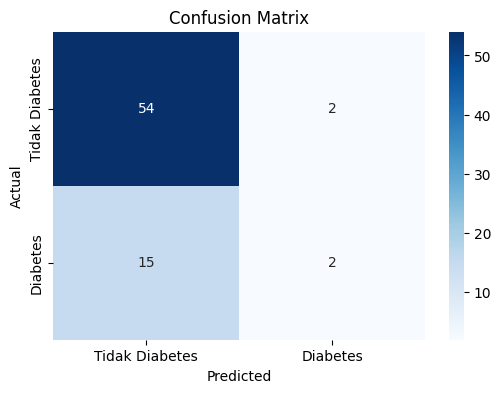

In [ ]:
# Evaluasi
print("=== EVALUASI MODEL ===")
print("Akurasi:", round(accuracy_score(y_test, y_pred) * 100, 2), "%")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
labels = ['Tidak Diabetes', 'Diabetes']

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Feature Selection

In [ ]:
# Menggunakan RFE (Recursive Feature Elimination)

from sklearn.feature_selection import RFE
model = RandomForestClassifier(random_state=42)
rfe_selector = RFE(estimator=model, n_features_to_select=4)  # Memilih 2 fitur
X_train_rfe = rfe_selector.fit_transform(X_train, y_train)
X_test_rfe = rfe_selector.transform(X_test)

print("Fitur yang dipilih dengan Wrapper Methods:", rfe_selector.get_support(indices=True))

Fitur yang dipilih dengan Wrapper Methods: [1 5 6 7]


# Tuning Hyperparameter

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train_rfe, y_train)

# Pilih model terbaik
best_rf_rfe = grid_search.best_estimator_

# Prediksi
y_pred_rfe = best_rf_rfe.predict(X_test_rfe)

Fitting 3 folds for each of 81 candidates, totalling 243 fits


=== EVALUASI MODEL ===
Akurasi: 80.82 %

Classification Report:
               precision    recall  f1-score   support

         0.0       0.83      0.95      0.88        56
         1.0       0.67      0.35      0.46        17

    accuracy                           0.81        73
   macro avg       0.75      0.65      0.67        73
weighted avg       0.79      0.81      0.79        73



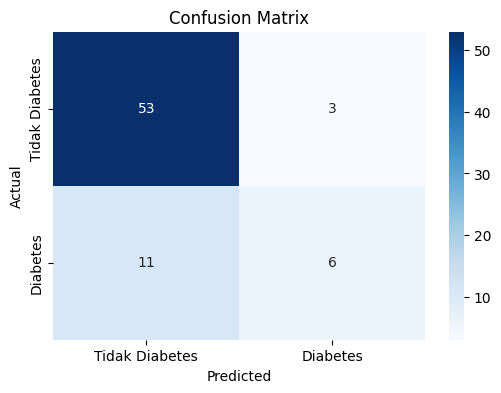

In [ ]:
# Evaluasi
print("=== EVALUASI MODEL ===")
print("Akurasi:", round(accuracy_score(y_test, y_pred_rfe) * 100, 2), "%")
print("\nClassification Report:\n", classification_report(y_test, y_pred_rfe))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_rfe)
labels = ['Tidak Diabetes', 'Diabetes']

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Integrasi Model ke API

In [ ]:
#integrate model ke api

from flask import Flask, request, jsonify

app = Flask(__name__)

@app.route('/predict', methods=['POST'])
def predict():
    data = request.get_json(force=True)
    prediction = best_rf_rfe.predict([data])
    return jsonify({'prediction': prediction[0]})